## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    rc={
        "axes.titlesize": 36,
        "axes.labelsize": 32,
        "lines.linewidth": 5,
        "lines.markersize": 24,
        "xtick.labelsize": 32,
        "ytick.labelsize": 32,
        'legend.fontsize': 24,
        'figsize': (15, 15),
    }
)
sns.color_palette("dark")

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')

FIG_DIR = os.path.join(
    os.path.dirname(os.path.dirname(glucose_ts.__file__)),
    'presentations',
    'results_outline',
    'images'
)


<Figure size 432x288 with 0 Axes>

# Calibration in Medium

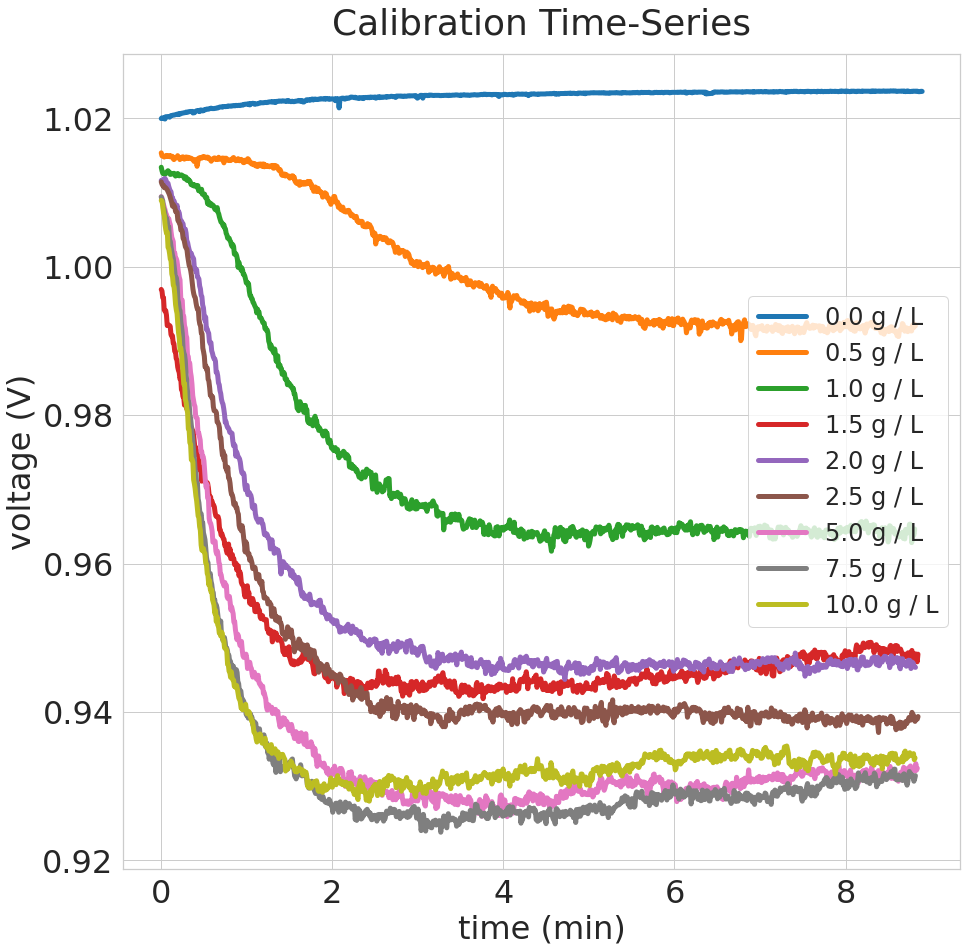

In [2]:
calibration_curves = sorted(
    [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'calibration', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'calibration'
            )
        )
    ],
    key=lambda one: one.real_concentration
)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

for one_curve in calibration_curves:
    
    ax.plot(
        one_curve.points_in_time,
        one_curve.voltages,
        label='%3.1f g / L' % one_curve.real_concentration,
    )

ax.set_xlabel('time (min)')
ax.set_ylabel('voltage (V)')

ax.set_title('Calibration Time-Series', pad=20)
ax.legend()

fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_time_series.png'
    ),
    transparent=True,
)


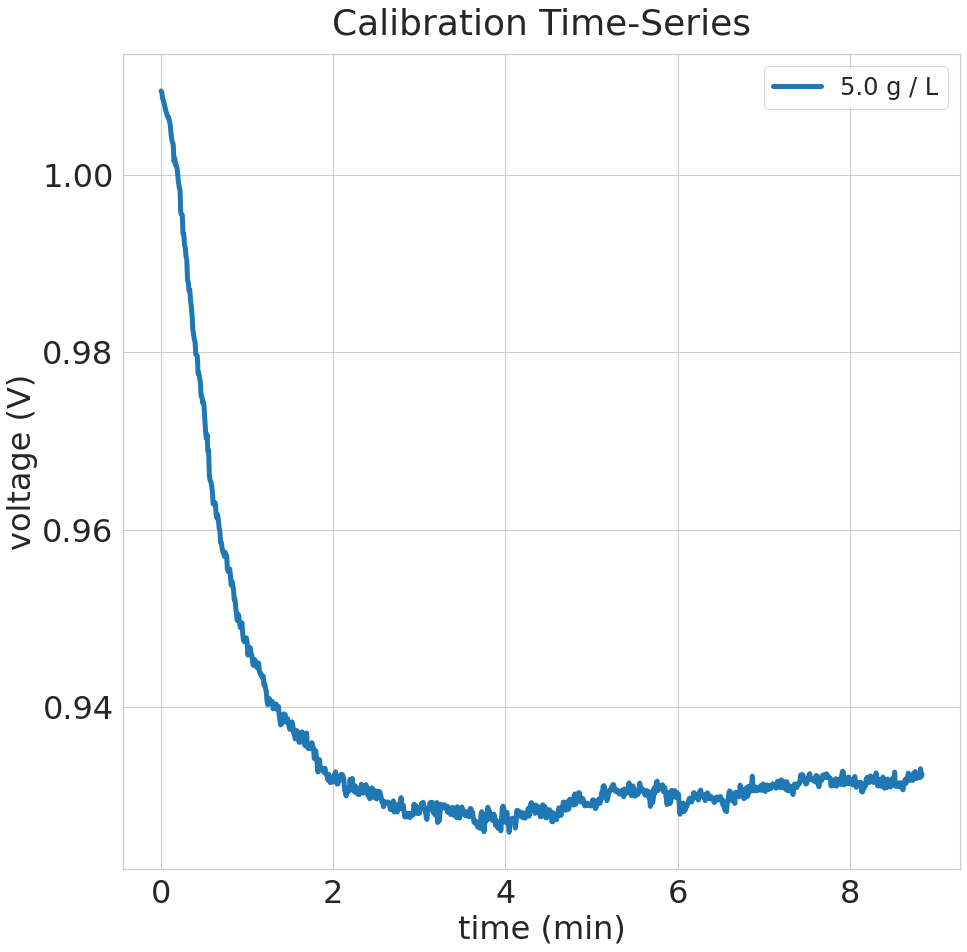

In [3]:

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.plot(
    calibration_curves[-3].points_in_time,
    calibration_curves[-3].voltages,
    label='%3.1f g / L' % calibration_curves[-3].real_concentration,
)

ax.set_xlabel('time (min)')
ax.set_ylabel('voltage (V)')

ax.set_title('Calibration Time-Series', pad=20)
ax.legend()

fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_5_gramm.png'
    ),
    transparent=True,
)


In [10]:
unlabeled_curves = sorted(
    [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, file))
        for file in os.listdir(DATA_DIR)
        if file.startswith('Data')
    ],
    key=lambda one: one.real_concentration
)
len(unlabeled_curves)

batch_samples = [
    glucose_ts.data.read_glucose_ts(
        os.path.join(DATA_DIR, 'batch_samples', file),
        comment=file.split('.')[0],
    )
    for file in os.listdir(
        os.path.join(
            DATA_DIR,
            'batch_samples'
        )
    )
]
batch_samples[0]

GlucoseTS(points_in_time=array([0.00000000e+00, 8.70000000e-03, 1.76666667e-02, 2.63833333e-02,
       3.51000000e-02, 4.40500000e-02, 5.28000000e-02, 6.17333333e-02,
       7.04666667e-02, 7.94166667e-02, 8.81833333e-02, 9.69166667e-02,
       1.05950000e-01, 1.14700000e-01, 1.23700000e-01, 1.32466667e-01,
       1.41500000e-01, 1.50250000e-01, 1.59050000e-01, 1.68116667e-01,
       1.76966667e-01, 1.85983333e-01, 1.94800000e-01, 2.03816667e-01,
       2.12583333e-01, 2.21633333e-01, 2.30366667e-01, 2.39083333e-01,
       2.48100000e-01, 2.56816667e-01, 2.65800000e-01, 2.74533333e-01,
       2.83500000e-01, 2.92200000e-01, 3.00950000e-01, 3.09933333e-01,
       3.18666667e-01, 3.27600000e-01, 3.36316667e-01, 3.45283333e-01,
       3.54066667e-01, 3.63016667e-01, 3.71766667e-01, 3.80483333e-01,
       3.89433333e-01, 3.98166667e-01, 4.07116667e-01, 4.15850000e-01,
       4.24800000e-01, 4.33533333e-01, 4.42316667e-01, 4.51300000e-01,
       4.60033333e-01, 4.68983333e-01, 4.77716667e-0

In [16]:
CUT_OFF_IDX = 200


glucose_model = glucose_ts.models.exponential_decay.get_glucose_model(
    calibration_curves,
    avg_start_idx=700,
)

voltage_model = glucose_ts.models.generalized_logistics.train_bayesian_voltage_model(
    calibration_curves + unlabeled_curves,
)


In [23]:
CUT_OFF_IDX = 200

volt_predictions_for_batch_samples = [
    voltage_model.predict(label_series.voltages[np.newaxis, :CUT_OFF_IDX])[0, :]
    for label_series in batch_samples
]

In [25]:
glucose_prediction_from_volt_prediction = [
    glucose_model.predict(one_volt_prediction[np.newaxis, :])
    for one_volt_prediction in volt_predictions_for_batch_samples
]

glucose_prediction_from_real_volts = [
    glucose_model.predict(volts[np.newaxis, :])
    for time, volts, _, _ in batch_samples
]

/home/christoph/git_projects/glucose-prediction/glucose_ts/models/exponential_decay.py:233: RuntimeWarning: invalid value encountered in log
  return -1 / B * np.log(


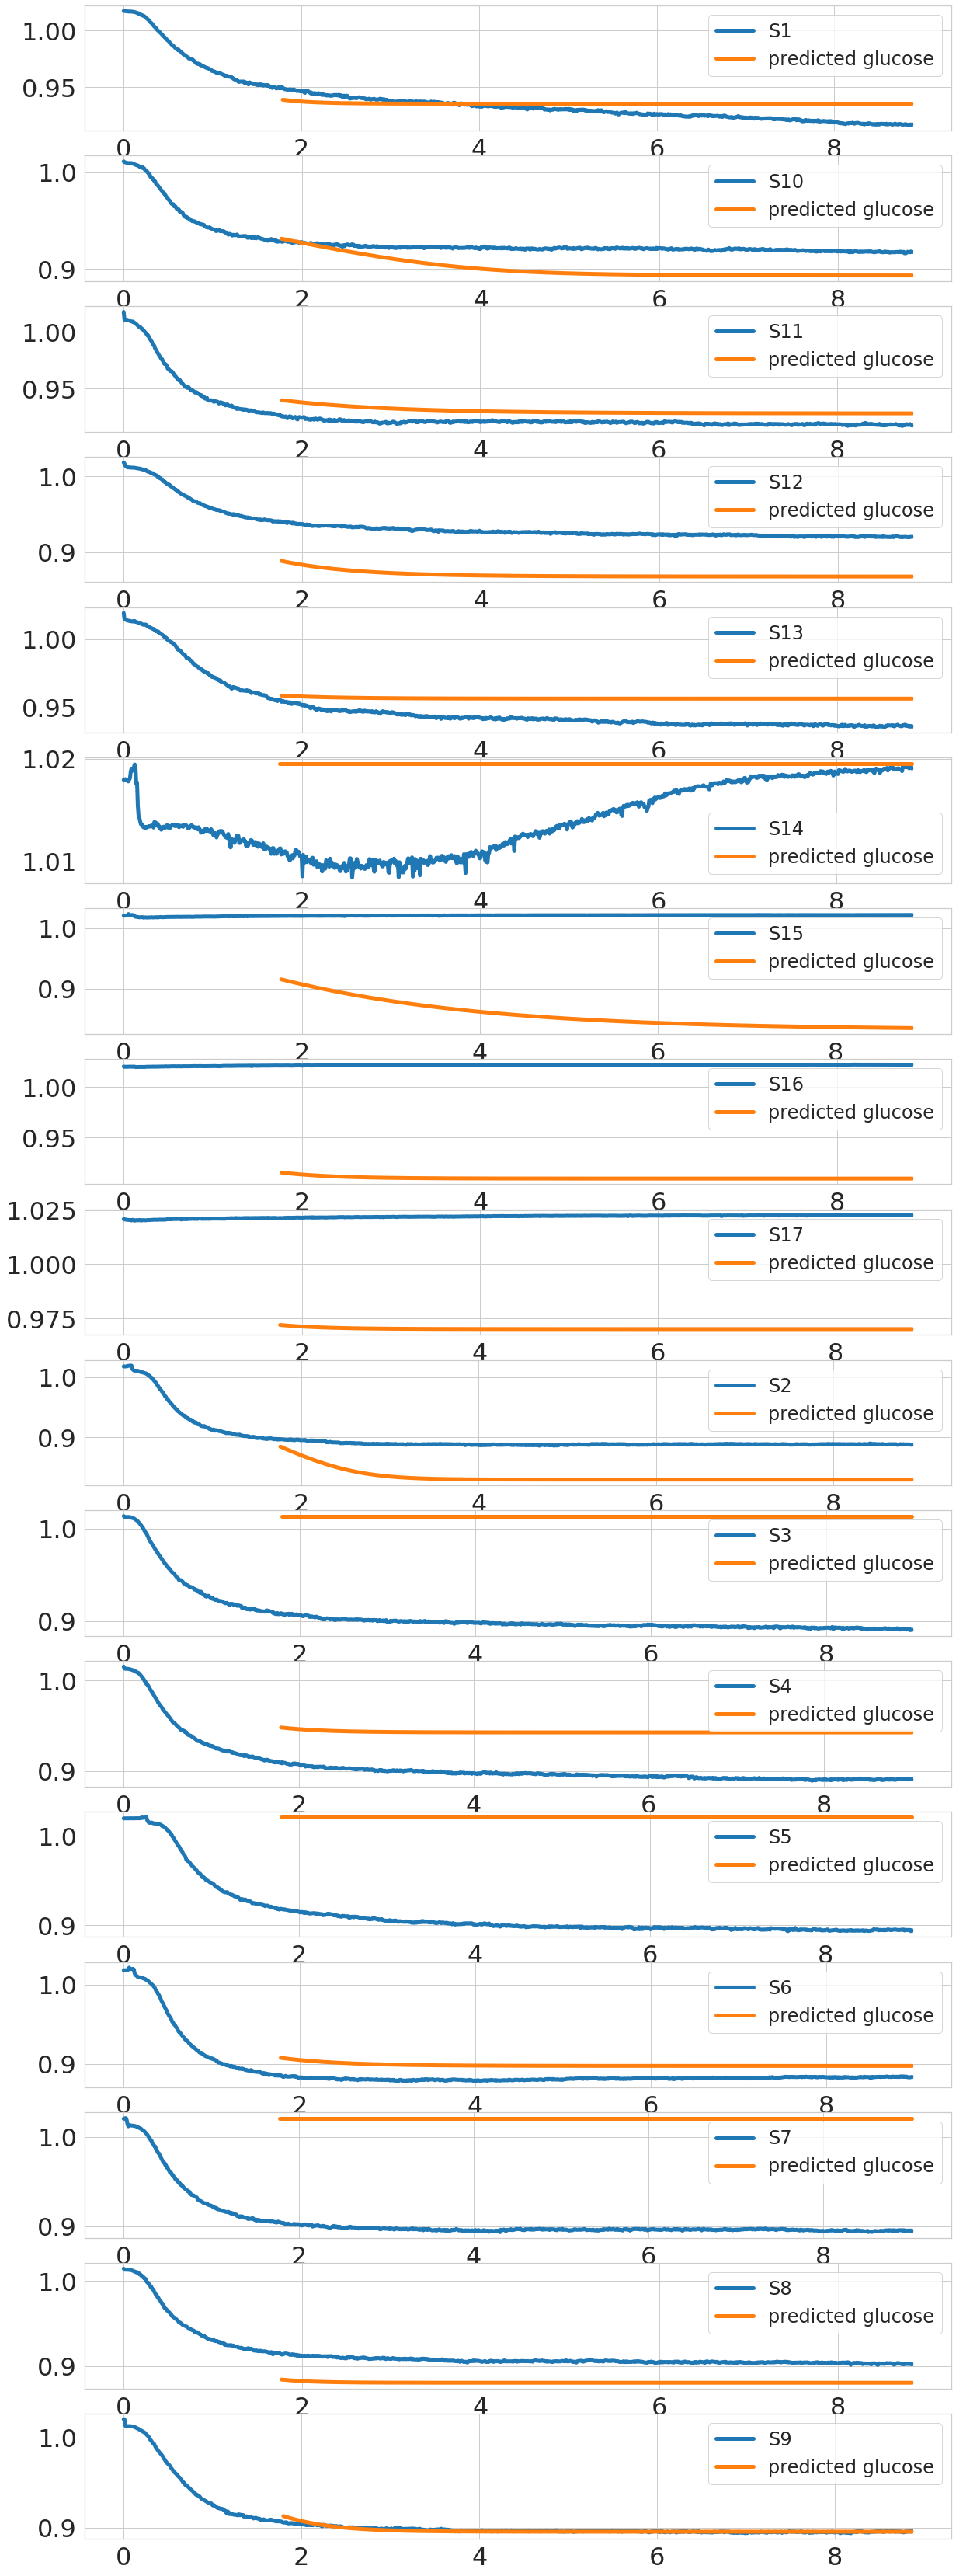

In [28]:


fig, axes = plt.subplots(len(batch_samples), 1, figsize=(20, 60))


for ax, label_series, volt_prediction in zip(
    axes.flatten(),
    sorted(batch_samples, key=lambda one: one.comment),
    volt_predictions_for_batch_samples,
):
    ax.plot(
        label_series.points_in_time,
        label_series.voltages,
        label=label_series.comment
    
    )
    ax.plot(
        label_series.points_in_time[CUT_OFF_IDX:],
        volt_prediction,
        label='predicted glucose'
    )
    ax.legend()





In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

results = [
    (
        np.mean(volt_predictions[0, -300:]),
        glucose_prediction,
        np.mean(real_series.voltages[-300:]),
        real_series.real_concentration
    )   
    for volt_predictions, glucose_prediction, real_series in sorted(
        val_predictions_and_labels,
        key=lambda one: one[2].real_concentration
    )
]


for (final_volt_prediction, glc_prediction, final_voltage, real_concentration), color in zip(
    results,
    ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
):
    ax.scatter(
        final_volt_prediction,
        glc_prediction,
        label=('%4.1f g / L' % real_concentration),
        marker='o',
        c=color,
    )
    ax.scatter(
        final_voltage,
        real_concentration,
        label=('%4.1f g / L' % real_concentration),
        marker='X',
        c=color
    )

ax.legend()
ax.set_title('Glucose ')

In [ ]:
from sklearn import metrics

voltage_values = [
    (final_voltage, final_volt_prediction)
    for final_volt_prediction, glc_prediction, final_voltage, real_concentration in results
]

glucose_values = [
    (real_concentration, glc_prediction)
    for final_volt_prediction, glc_prediction, final_voltage, real_concentration in results
    if glc_prediction < 100
]

glucose_below_2_5 = [
    (real_concentration, glc_prediction)
    for final_volt_prediction, glc_prediction, final_voltage, real_concentration in results
    if real_concentration <= 2.5
    
]


print('Final Voltages: %s' % glucose_ts.evaluation.both_models.get_performance_kpis((*zip(*voltage_values))))
print('Glucose Values %s' % glucose_ts.evaluation.both_models.get_performance_kpis((*zip(*glucose_values))))
print('Glucose Values <= 2.5 g / L %s' % glucose_ts.evaluation.both_models.get_performance_kpis((*zip(*glucose_below_2_5))))